In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import numpy as np
from tensorflow.keras.preprocessing import image
from skimage.io import imread
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr


In [4]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

print(labelStringArr)

img_df.sample(n=10)

['MKD' 'HRV' 'ISL' 'IRL' 'ITA' 'HUN' 'LVA' 'GBR' 'FRA' 'LTU' 'AUT' 'SVN'
 'FIN' 'ESP' 'NOR' 'BGR' 'PRT' 'SVK' 'BEL' 'EST' 'POL' 'CZE' 'NLD' 'CHE'
 'DNK' 'SWE']


,path,label
22178,/home/pascal_steiger/Downloads/data/CZE/img_CZ...,CZE
2219,/home/pascal_steiger/Downloads/data/ISL/img_IS...,ISL
25885,/home/pascal_steiger/Downloads/data/SWE/img_SW...,SWE
14570,/home/pascal_steiger/Downloads/data/NOR/img_NO...,NOR
757,/home/pascal_steiger/Downloads/data/MKD/img_MK...,MKD
2809,/home/pascal_steiger/Downloads/data/ISL/img_IS...,ISL
2963,/home/pascal_steiger/Downloads/data/ISL/img_IS...,ISL
10523,/home/pascal_steiger/Downloads/data/AUT/img_AU...,AUT
9981,/home/pascal_steiger/Downloads/data/LTU/img_LT...,LTU
4237,/home/pascal_steiger/Downloads/data/ITA/img_IT...,ITA


In [5]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)


                                                    path label
7400   /home/pascal_steiger/Downloads/data/GBR/img_52...   GBR
7715   /home/pascal_steiger/Downloads/data/GBR/img_53...   GBR
7669   /home/pascal_steiger/Downloads/data/GBR/img_51...   GBR
23735  /home/pascal_steiger/Downloads/data/CHE/img_47...   CHE
8177   /home/pascal_steiger/Downloads/data/FRA/img_43...   FRA
(21234, 2)
                                                    path label
21276  /home/pascal_steiger/Downloads/data/POL/img_PO...   POL
17235  /home/pascal_steiger/Downloads/data/PRT/img_PR...   PRT
3789   /home/pascal_steiger/Downloads/data/IRL/img_53...   IRL
22150  /home/pascal_steiger/Downloads/data/CZE/img_CZ...   CZE
18918  /home/pascal_steiger/Downloads/data/BEL/img_50...   BEL
(5309, 2)


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(299, 299),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(299, 299),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 21234 validated image filenames belonging to 26 classes.
Found 5309 validated image filenames belonging to 26 classes.


In [10]:
with tf.device("/device:GPU:1"):
    from tensorflow.keras.applications.xception import Xception
    tl_xcep = Xception(include_top=True,weights="imagenet")
    for layer in tl_xcep.layers:
        layer.trainable = False

    for layer in tl_xcep.layers[-26:]:
        layer.trainable = True 
    print(tl_xcep.summary())

91889664/91884032 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [12]:
with tf.device("/device:GPU:1"):
    tl_xcep.layers.pop()
    tl_xcep.layers.pop()
    tl_xcep.layers.pop()


    I = Input(shape=(299, 299, 3))



    x = tl_xcep(I)

    flat= Flatten()(x)


    dense = Dense(4096, activation='relu', name='denserelu')(flat)

    dense2 = Dense(2048, activation='relu', name='denserelu2')(dense)

    dense3 = Dense(26, activation='softmax', name='my_dense')(dense2)

    #prediction = Dense(26, activation='softmax', name='prediction')



    #out2 = prediction(x)


    new_model2 = tf.keras.Model(I, dense3)

    new_model2.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 1000)              22910480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
denserelu (Dense)            (None, 4096)              4100096   
_________________________________________________________________
denserelu2 (Dense)           (None, 2048)              8390656   
_________________________________________________________________
my_dense (Dense)             (None, 26)                53274     
Total params: 35,454,506
Trainable params: 22,458,850
Non-trainable params: 12,995,656
______________________________________

In [13]:
# define callbacks for early stopping

early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [14]:
with tf.device("/device:GPU:1"):
    new_model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

with tf.device("/device:GPU:1"):
    history = new_model2.fit(
          train_generator,
          epochs=200,
          verbose = 1,
          callbacks=callbacks,
          #steps_per_epoch=2000 // 32,
          validation_data=validation_generator)
    new_model2.save('CNN-TL_xcep_v1.h5')

Epoch 1/200
664/664 [==============================] - 578s 859ms/step - loss: 2.9986 - sparse_categorical_accuracy: 0.1093 - val_loss: 2.7629 - val_sparse_categorical_accuracy: 0.1484
Epoch 2/200
664/664 [==============================] - 558s 840ms/step - loss: 2.6129 - sparse_categorical_accuracy: 0.1878 - val_loss: 2.5508 - val_sparse_categorical_accuracy: 0.2093
Epoch 3/200
664/664 [==============================] - 562s 846ms/step - loss: 2.3654 - sparse_categorical_accuracy: 0.2599 - val_loss: 2.2748 - val_sparse_categorical_accuracy: 0.2963
Epoch 4/200
664/664 [==============================] - 558s 840ms/step - loss: 2.1562 - sparse_categorical_accuracy: 0.3144 - val_loss: 2.0647 - val_sparse_categorical_accuracy: 0.3424
Epoch 5/200
664/664 [==============================] - 557s 838ms/step - loss: 2.0020 - sparse_categorical_accuracy: 0.3583 - val_loss: 2.0770 - val_sparse_categorical_accuracy: 0.3470
Epoch 6/200
664/664 [==============================] - 554s 834ms/step - lo

664/664 [==============================] - 544s 819ms/step - loss: 0.0969 - sparse_categorical_accuracy: 0.9683 - val_loss: 3.1497 - val_sparse_categorical_accuracy: 0.5208
Epoch 45/200
664/664 [==============================] - 545s 820ms/step - loss: 0.0951 - sparse_categorical_accuracy: 0.9684 - val_loss: 3.2909 - val_sparse_categorical_accuracy: 0.5186
Epoch 46/200
664/664 [==============================] - 544s 819ms/step - loss: 0.0931 - sparse_categorical_accuracy: 0.9692 - val_loss: 3.3169 - val_sparse_categorical_accuracy: 0.5176
Epoch 47/200
664/664 [==============================] - 580s 873ms/step - loss: 0.0901 - sparse_categorical_accuracy: 0.9696 - val_loss: 3.1955 - val_sparse_categorical_accuracy: 0.5167
Epoch 48/200
664/664 [==============================] - 545s 819ms/step - loss: 0.0840 - sparse_categorical_accuracy: 0.9736 - val_loss: 3.3145 - val_sparse_categorical_accuracy: 0.5170
Epoch 49/200
664/664 [==============================] - 546s 822ms/step - loss: 0.0

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


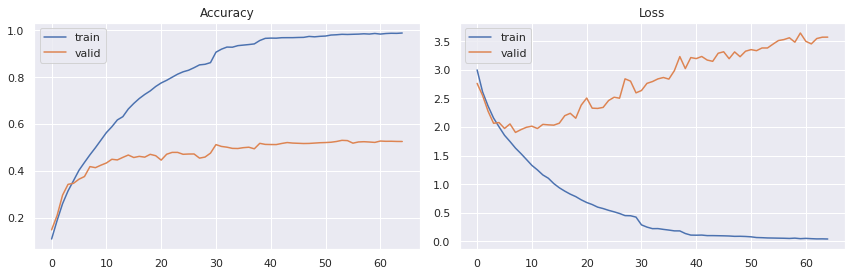

In [15]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(224,224)-tl_xcepv1.png')

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        "/mnt/data/testing3/",
        target_size=(224, 224),
        batch_size=1,
        class_mode='sparse',
        shuffle=False)

res=validmodel2.predict(test_generator, steps=len(test_generator), verbose=1)
y_classes = res.argmax(axis=-1)
print(labelStringArr)
label2 = np.sort(labelStringArr)
print(label2)
print(y_classes)

filenames=test_generator.filenames
label_map = (train_generator.class_indices)
print(label_map)
preds = []
labels = []
for i in range(len(filenames)):
    #print(res[i])
    preds.append(res[i][np.argmax(res[i])])
    labels.append(label2[y_classes[i]])




# Data frame
results=pd.DataFrame({"file":filenames, "class":labels, "pr":preds})

results.to_csv("res2.csv", index = False)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=5309
batch_size=32
Y_pred = validmodel2.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = label2
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))